# PINN para Aerofólio em regime escoamento transônico

## Carregar bibliotecas deepxde e outras necessárias

In [1]:
# carrega o deepxde

!pip install deepxde

# Troca o backend para o pytorch. Caso queira usar o PaddlePaddle, basta trocar pytorch por paddle (depois de instalá-lo).
import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Troca o tipo de ponto flutuante para 64 bit, originalmente é 32 bit (essa alteração é necessária)
dde.config.set_default_float('float64')

import numpy as np

# Caso precise usar alguma função específica do pytorch (não é o caso deste notebook)
import torch
# Exemplo: caso precise usar um seno, deve-se usar: torch.sin(...)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


In [2]:
# Define a semente
seed = 42

# Fixa a semente para o PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Fixa a semente para o NumPy
np.random.seed(seed)

## Modelo

As equações do escoamento foram reescritas em forma adimensional, seguindo uma abordagem baseada em escalas características do problema (regime transônico). A estratégia é baseada na seção II.C do artigo [2408.17364v3](https://arxiv.org/abs/2408.17364), onde todas as variáveis físicas são normalizadas por grandezas de referência.
As variáveis utilizadas são:

- $ \rho $: densidade adimensional (referência: $ \rho_\inf $)
- $ \rho u, \rho v $: momento linear nas direções $ x $ e $ y $
- $ \rho E $: energia total (interna + cinética)

A pressão adimensional é calculada como:

$
p = (\gamma - 1) \left( \rho E - \frac{1}{2} \rho (u^2 + v^2) \right)
$

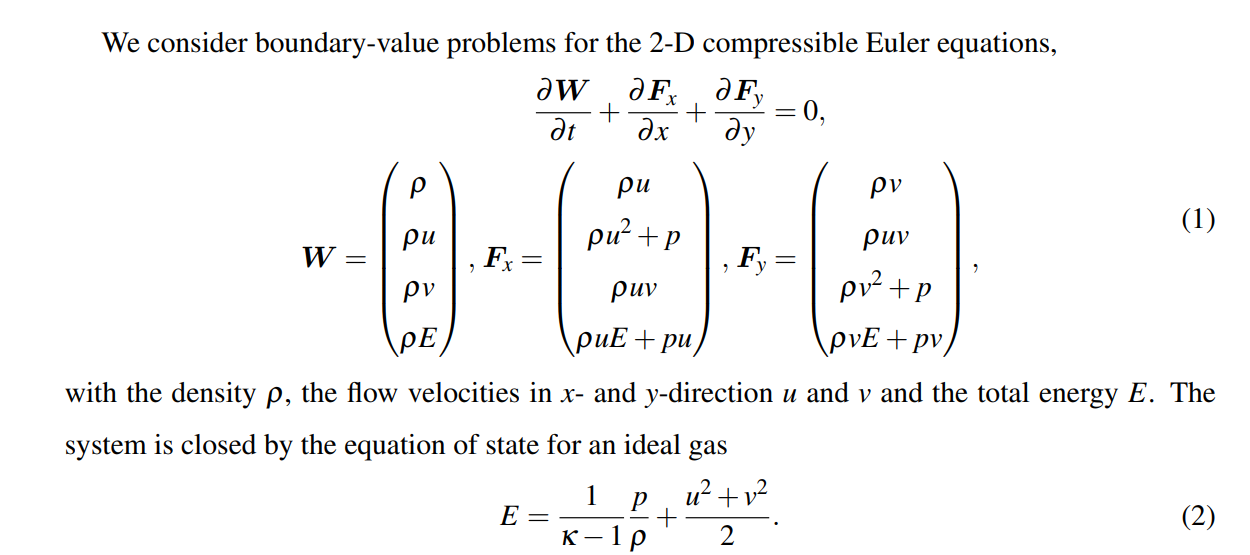

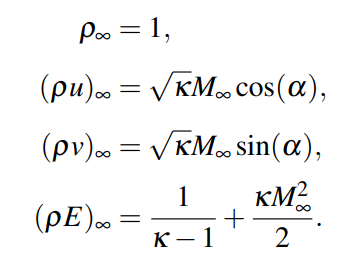


### Construção das EDPs em DeepXDE

In [3]:
def pde_viscous_compressible(x, y):
    rho = y[:, 0:1]
    u = y[:, 1:2]
    v = y[:, 2:3]
    p = y[:, 3:4]

    gamma = 1.4
    g = gamma/(gamma-1)

    # valores de referencia
    rho_ref = 1.225
    u_ref = 340
    p_ref = 101325.0

    h = p_ref/(rho_ref * u_ref**2)

    rho_x = dde.grad.jacobian(y, x, i=0, j=0)
    rho_y = dde.grad.jacobian(y, x, i=0, j=1)
    u_x = dde.grad.jacobian(y, x, i=1, j=0)
    u_y = dde.grad.jacobian(y, x, i=1, j=1)
    v_x = dde.grad.jacobian(y, x, i=2, j=0)
    v_y = dde.grad.jacobian(y, x, i=2, j=1)
    p_x = dde.grad.jacobian(y, x, i=3, j=0)
    p_y = dde.grad.jacobian(y, x, i=3, j=1)

    eq1 = rho_x * u + rho * u_x + rho_y * v + rho * v_y  # Continuidade
    eq2 = rho_x * u**2 + rho * 2 * u * u_x + h * p_x + rho_y * u * v + rho * u_y * v + rho * u * v_y  # Momentum x
    eq3 = rho_x * u * v + rho * u_x * v + rho * u * v_x + rho_y * v**2 + rho * 2 * v * v_y + h * p_y  # Momentum y
    eq4 = h * g*(p_x * u + p * u_x + p_y * v + p * v_y) + rho_x * (u**3 + u * v**2) / 2 + rho * (3 * u_x * u**2 + u_x * v**2 + 2 * u * v_x * v) / 2 + rho_y * (v * u**2 + v**3) / 2 + rho * (3 * v_y * v**2 + u**2 * v_y + 2 * u * u_y * v) / 2

    return [eq1, eq2, eq3, eq4]

### Condições de contorno

In [4]:
import math
# Domínio externo (retângulo grande para simular situação de túnel de vento)
escala = 2
x_min, x_max = -15, escala*25
y_min, y_max = -escala*25, escala*25
geom = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])

# Geometria do aerofólio
airfoil_coords =  np.array([
    (1.0000000, 0.0000000), (0.9964600, 0.0002700), (0.9862500, 0.0013100), (0.9701700, 0.0033000),
    (0.9488500, 0.0059100), (0.9224700, 0.0087600), (0.8911800, 0.0118800),
    (0.8553800, 0.0153200), (0.8156000, 0.0190800), (0.7723700, 0.0230800),
    (0.7262700, 0.0272200), (0.6778900, 0.0313500), (0.6277700, 0.0353500),
    (0.5764700, 0.0390900), (0.5245600, 0.0424600), (0.4726100, 0.0453600),
    (0.4211600, 0.0477000), (0.3707700, 0.0493800), (0.3219600, 0.0503400),
    (0.2752300, 0.0505100), (0.2310600, 0.0498200), (0.1898700, 0.0482400),
    (0.1520300, 0.0457400), (0.1178900, 0.0423300), (0.0877400, 0.0380200),
    (0.0617900, 0.0328700), (0.0402400, 0.0269700), (0.0231800, 0.0204100),
    (0.0106500, 0.0134500), (0.0027600, 0.0064500), (0.0000000, 0.0000000),
    (0.0027600, -0.0064500), (0.0106600, -0.0134500), (0.0231900, -0.0204100),
    (0.0402400, -0.0269700), (0.0618000, -0.0328700), (0.0877400, -0.0380200),
    (0.1179000, -0.0423300), (0.1520400, -0.0457400), (0.1898700, -0.0482400),
    (0.2310700, -0.0498200), (0.2752400, -0.0505100), (0.3219700, -0.0503400),
    (0.3707700, -0.0493800), (0.4211700, -0.0476900), (0.4726200, -0.0453600),
    (0.5245700, -0.0424600), (0.5764800, -0.0390800), (0.6277800, -0.0353400),
    (0.6779000, -0.0313500), (0.7262900, -0.0272200), (0.7723800, -0.0230800),
    (0.8156100, -0.0190700), (0.8553900, -0.0153200), (0.8911900, -0.0118800),
    (0.9224800, -0.0087600), (0.9488600, -0.0059100), (0.9701800, -0.0033000),
    (0.9862600, -0.0013100), (0.9964700, -0.0002700)
])

# aerofólio #2
# airfoil_coords = escala * np.array([
#     (1.0000000, 0.0012600), (0.9928006, 0.0032198), (0.9798895, 0.0066835),
#     (0.9635184, 0.0109823), (0.9445469, 0.0158354), (0.9234998, 0.0210604),
#     (0.9007495, 0.0265227), (0.8765830, 0.0321168), (0.8512328, 0.0377572),
#     (0.8248944, 0.0433730), (0.7977362, 0.0489045), (0.7699063, 0.0543008),
#     (0.7415373, 0.0595184), (0.7127487, 0.0645195), (0.6836500, 0.0692712),
#     (0.6543419, 0.0737448), (0.6249182, 0.0779148), (0.5954661, 0.0817592),
#     (0.5660677, 0.0852584), (0.5368005, 0.0883955), (0.5077378, 0.0911557),
#     (0.4789491, 0.0935267), (0.4505011, 0.0954983), (0.4224571, 0.0970626),
#     (0.3948782, 0.0982103), (0.3678229, 0.0988053), (0.3413476, 0.0987893),
#     (0.3155065, 0.0981781), (0.2903524, 0.0969911), (0.2659361, 0.0952510),
#     (0.2423068, 0.0929845), (0.2195125, 0.0902210), (0.1975998, 0.0869933),
#     (0.1766138, 0.0833369), (0.1565988, 0.0792897), (0.1375977, 0.0748918),
#     (0.1196525, 0.0701852), (0.1028043, 0.0652129), (0.0870931, 0.0600189),
#     (0.0725582, 0.0546478), (0.0592379, 0.0491435), (0.0471700, 0.0435495),
#     (0.0363913, 0.0379076), (0.0269381, 0.0322577), (0.0188458, 0.0266369),
#     (0.0121494, 0.0210790), (0.0068832, 0.0156139), (0.0030809, 0.0102667),
#     (0.0007756, 0.0050573), (0.0000000, 0.0000000), (0.0007756, -0.0047474),
#     (0.0030809, -0.0090391), (0.0068832, -0.0128843), (0.0121494, -0.0162931),
#     (0.0188458, -0.0192762), (0.0269381, -0.0218453), (0.0363913, -0.0240133),
#     (0.0471700, -0.0257940), (0.0592379, -0.0272029), (0.0725582, -0.0282569),
#     (0.0870931, -0.0289743), (0.1028043, -0.0293755), (0.1196525, -0.0294825),
#     (0.1375977, -0.0293193), (0.1565988, -0.0289118), (0.1766138, -0.0282876),
#     (0.1975998, -0.0274762), (0.2195125, -0.0265089), (0.2423068, -0.0254180),
#     (0.2659361, -0.0242376), (0.2903524, -0.0230023), (0.3155065, -0.0217477),
#     (0.3413476, -0.0205094), (0.3678229, -0.0193230), (0.3948782, -0.0182234),
#     (0.4224571, -0.0171746), (0.4505011, -0.0160650), (0.4789491, -0.0149118),
#     (0.5077378, -0.0137351), (0.5368005, -0.0125542), (0.5660677, -0.0113870),
#     (0.5954661, -0.0102497), (0.6249182, -0.0091567), (0.6543419, -0.0081203),
#     (0.6836500, -0.0071506), (0.7127487, -0.0062555), (0.7415373, -0.0054401),
#     (0.7699063, -0.0047076), (0.7977362, -0.0040587), (0.8248944, -0.0034919),
#     (0.8512328, -0.0030041), (0.8765830, -0.0025904), (0.9007495, -0.0022449),
#     (0.9234998, -0.0019608), (0.9445469, -0.0017313), (0.9635184, -0.0015496),
#     (0.9798895, -0.0014106), (0.9928006, -0.0013115), (1.0000000, -0.0012600)
# ])

aerofolio = dde.geometry.Polygon(airfoil_coords)
domain = geom - aerofolio

# Funções de detecção de fronteira
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_min)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_max)

def boundary_top_bottom(x, on_boundary):
    return on_boundary and (np.isclose(x[1], y_min) or np.isclose(x[1], y_max))

def boundary_airfoil(x, on_boundary):
    return (on_boundary & aerofolio.on_boundary(x)).any()


# Variáveis de entrada
alpha_deg = 0
alpha = math.radians(alpha_deg)
rho_inf = 1
vel_mag = 0.8
u_inf = vel_mag*math.cos(alpha)
v_inf = vel_mag*math.sin(alpha)
p_inf = 1

# Condições de contorno
bc_left_rho = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: rho_inf , boundary_left, component=0)
bc_left_u = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: u_inf , boundary_left, component=1)
bc_left_v = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: v_inf , boundary_left, component=2)
bc_left_p = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: p_inf, boundary_left, component=3)

bc_right_rho = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: rho_inf , boundary_right, component=0)
bc_right_u = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: u_inf , boundary_right, component=1)
bc_right_v = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: v_inf , boundary_right, component=2)
bc_right_p = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: p_inf, boundary_right, component=3)

bc_top_bottom_rho = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: rho_inf , boundary_top_bottom, component=0)
bc_top_bottom_u = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: u_inf , boundary_top_bottom, component=1)
bc_top_bottom_v = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: v_inf , boundary_top_bottom, component=2)
bc_top_bottom_p = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: p_inf, boundary_top_bottom, component=3)

bc_wall_u = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: 0, boundary_airfoil, component=1)
bc_wall_v = dde.icbc.boundary_conditions.DirichletBC(domain, lambda x: 0, boundary_airfoil, component=2)

bcs_aerofolio = [bc_left_rho, bc_left_u, bc_left_v, bc_left_p, bc_wall_u, bc_wall_v, bc_top_bottom_rho, bc_top_bottom_u, bc_top_bottom_v, bc_top_bottom_p]


### Arquitetura

In [5]:
# Definindo a rede neural
layer_size = [2] + [65] * 6 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

### Treinamento

In [6]:
# Função que irá treinar o modelo, ela recebe o domínio desejado, as condições de contorno e o nome desejado para o modelo
def train_model(dominio, bcs, name, numd=6000, numb=1000, numt=750):
    data = dde.data.PDE(dominio, pde_viscous_compressible, bcs, num_domain=numd, num_boundary=numb, num_test=numt)
    model = dde.Model(data, net)

    lw = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # pesos unitários apenas, não foi necessário mudar

    resampler = dde.callbacks.PDEPointResampler(period=100)

    model.compile("adam", lr=1e-5, loss_weights=lw)
    losshistory, train_state = model.train(iterations=10000, callbacks=[resampler])

    model.compile("L-BFGS", loss_weights=lw)
    losshistory, train_state = model.train(callbacks=[resampler])


    dde.saveplot(losshistory, train_state, issave=True, isplot=True, output_dir=name)
    return model

Compiling model...
'compile' took 6.080949 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [4.32e-04, 7.53e-04, 2.59e-04, 1.10e-03, 1.78e+00, 7.02e-01, 8.34e-02, 1.14e+00, 2.35e-02, 3.15e-02, 6.87e-01, 6.38e-01, 3.98e-02, 8.68e-01]    [1.65e-04, 2.77e-04, 2.63e-04, 6.95e-04, 1.78e+00, 7.02e-01, 8.34e-02, 1.14e+00, 2.35e-02, 3.15e-02, 6.87e-01, 6.38e-01, 3.98e-02, 8.68e-01]    []  
1000      [4.96e-03, 1.60e-02, 1.85e-03, 3.73e-02, 1.62e-01, 6.18e-02, 2.01e-03, 1.37e-01, 5.24e-02, 5.18e-04, 3.67e-01, 1.73e-01, 3.36e-03, 3.26e-01]    [1.52e-03, 4.93e-03, 1.19e-03, 1.46e-02, 1.62e-01, 6.18e-02, 2.01e-03, 1.37e-01, 5.24e-02, 5.18e-04, 3.67e-01, 1.73e-01, 3.36e-03, 3.26e-01]    []  
2000      [2.43e-03

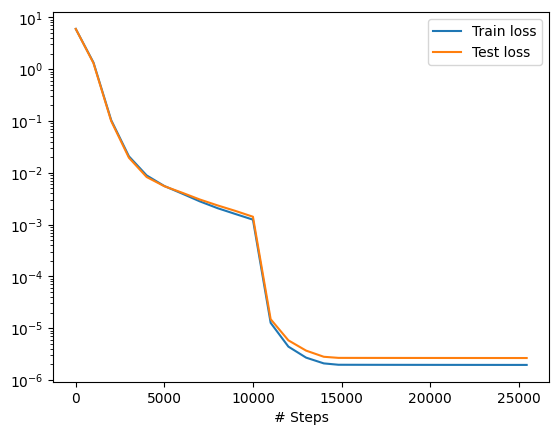

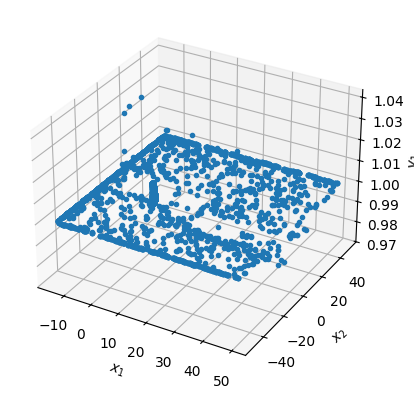

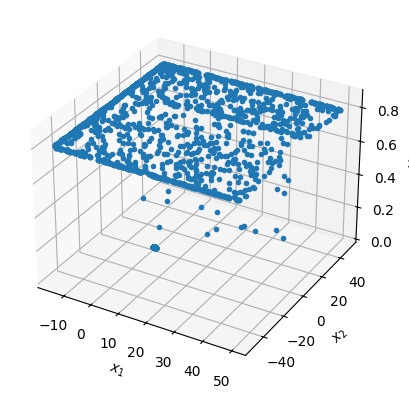

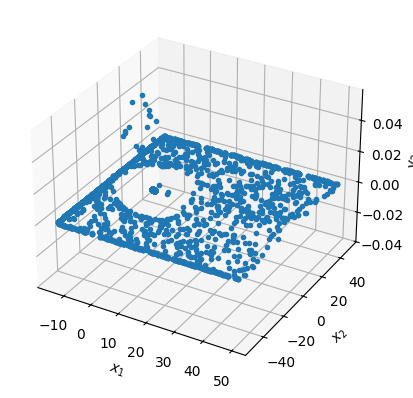

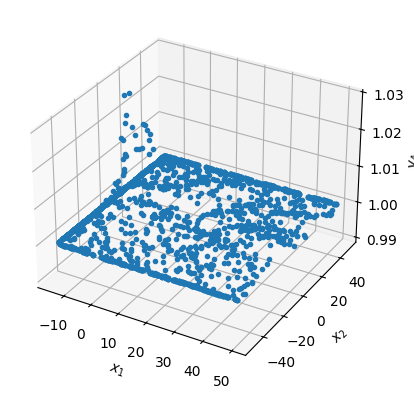

In [7]:
# Modelo do aerofolio
model_aerofolio = train_model(domain, bcs_aerofolio, "aerofolio")

### Resultados

In [8]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

escala = 25
resolution = 0.05
def plot_results(model, shape_name, geometry, shape_patch_fn):
    x = np.linspace(x_min*(escala/25), x_max*(escala/25), 1000)
    y = np.linspace(y_min*(escala/25), y_max*(escala/25), 1000)
    X, Y = np.meshgrid(x, y)
    points = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    u_ref = 340
    p_ref = 101325
    Z = model.predict(points)
    u, v, p = Z[:, 1].reshape(X.shape)*u_ref, Z[:, 2].reshape(X.shape)*u_ref, Z[:, 3].reshape(X.shape)*p_ref
    velocity_magnitude = np.sqrt(u**2 + v**2)

    x_zoom = np.linspace(x_min*resolution, x_max*resolution, 1000)
    y_zoom = np.linspace(y_min*resolution, y_max*resolution, 1000)
    X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)
    points_zoom = np.hstack((X_zoom.flatten()[:, None], Y_zoom.flatten()[:, None]))
    Z_zoom = model.predict(points_zoom)
    u_zoom, v_zoom, p_zoom = Z_zoom[:, 1].reshape(X_zoom.shape)*u_ref, Z_zoom[:, 2].reshape(X_zoom.shape)*u_ref, Z_zoom[:, 3].reshape(X_zoom.shape)*p_ref
    velocity_magnitude_zoom = np.sqrt(u_zoom**2 + v_zoom**2)

    # Plot do campo de velocidades
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, velocity_magnitude, levels=50, cmap="plasma")
    plt.colorbar(label="Velocity Magnitude [m/s]")
    plt.streamplot(X, Y, u, v, density=2, color='k', linewidth=0.8, arrowsize=0.5)
    plt.gca().add_patch(shape_patch_fn())  # Criar um novo shape para cada figura
    plt.xlabel("x [meters]")
    plt.ylabel("y [meters]")
    plt.legend()
    plt.show()

    # Plot do campo de velocidades (com zoom)
    plt.figure(figsize=(10, 8))
    plt.contourf(X_zoom, Y_zoom, velocity_magnitude_zoom, levels=50, cmap="plasma")
    plt.colorbar(label="Velocity Magnitude [m/s]")
    plt.streamplot(x_zoom, y_zoom, u_zoom, v_zoom, density=2, color='k', linewidth=0.8, arrowsize=0.5)
    plt.gca().add_patch(shape_patch_fn())  # Criar um novo shape para cada figura
    plt.xlabel("x [meters]")
    plt.ylabel("y [meters]")
    plt.legend()
    plt.show()

    # Plot do campo de pressão
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, p, levels=50, cmap="plasma")
    plt.colorbar(label="Pressure [Pa]", format = "%4.2e")
    plt.gca().add_patch(shape_patch_fn())  # Criar um novo shape para cada figura
    plt.xlabel("x [meters]")
    plt.ylabel("y [meters]")
    plt.legend()
    plt.show()

    # Plot do campo de pressão (com zoom)
    plt.figure(figsize=(10, 8))
    plt.contourf(X_zoom, Y_zoom, p_zoom, levels=50, cmap="plasma")
    plt.colorbar(label="Pressure [Pa]", format = "%3.2e")
    plt.gca().add_patch(shape_patch_fn())  # Criar um novo shape para cada figura
    plt.xlabel("x [meters]")
    plt.ylabel("y [meters]")
    plt.legend()
    plt.show()

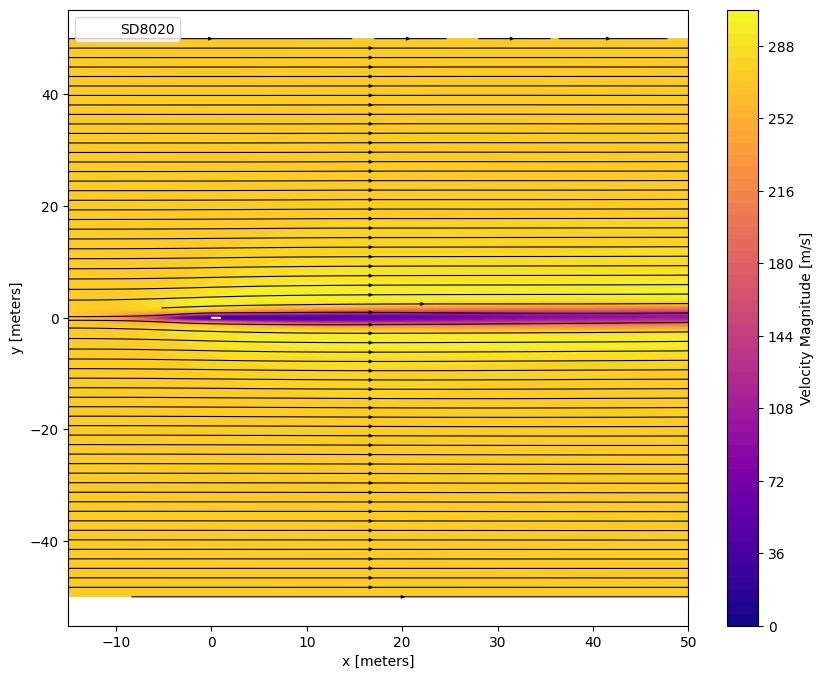

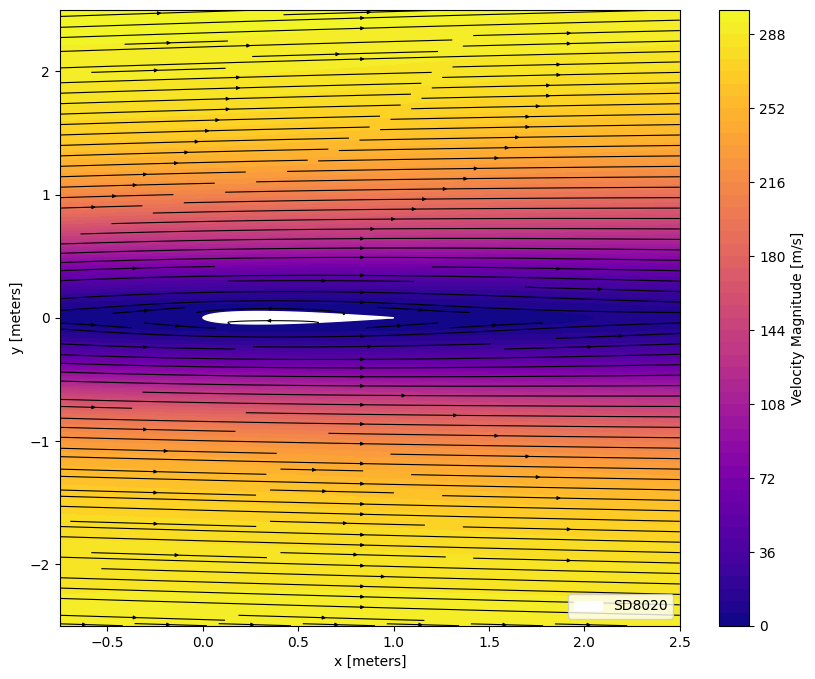

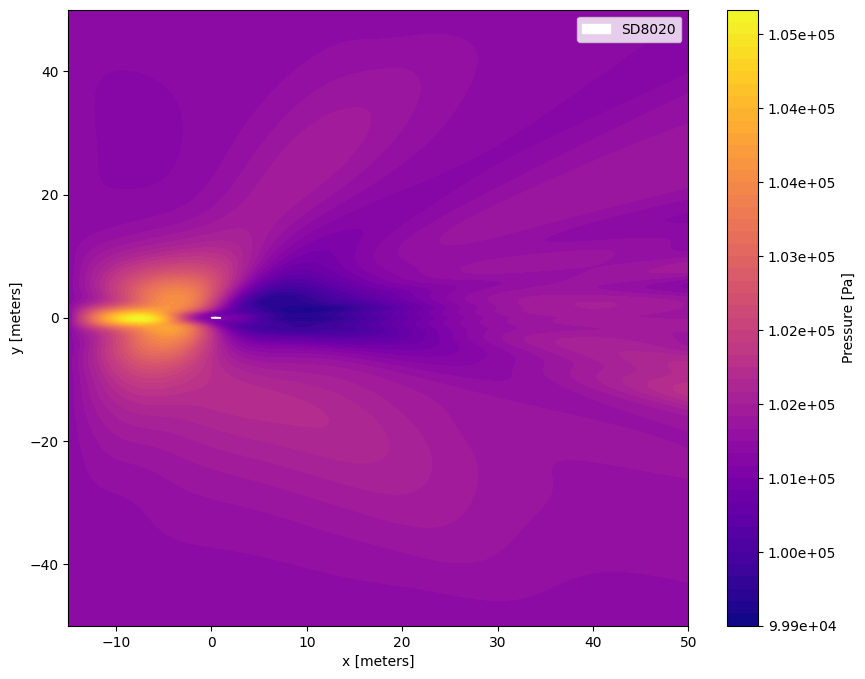

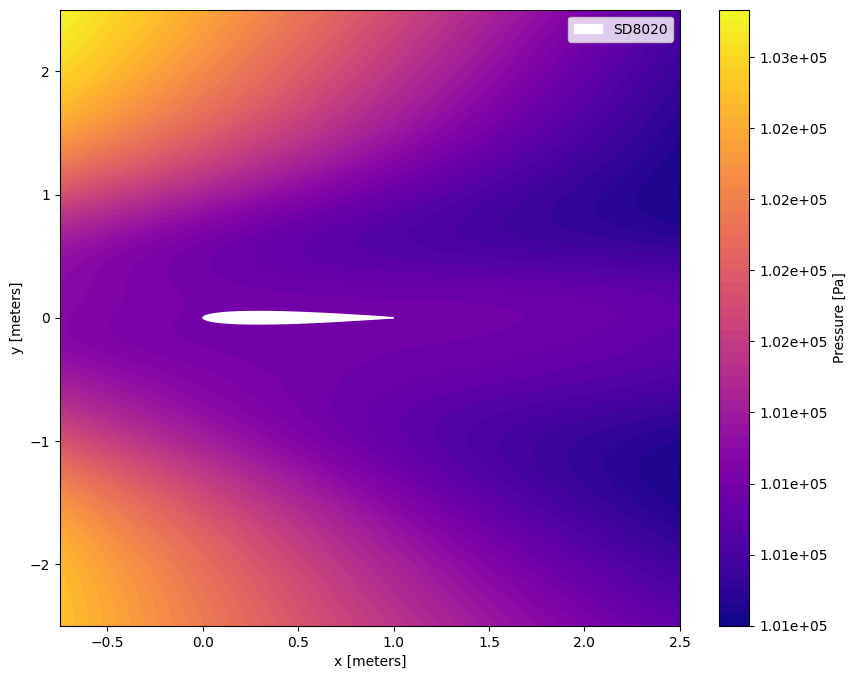

In [17]:
plot_results(model_aerofolio, "SD8020", domain, lambda: patches.Polygon(airfoil_coords, color='w', fill=True, label="SD8020"))

# Salva o Resultado

In [14]:
import pandas as pd
Z = model_aerofolio.predict(airfoil_coords)
df = pd.DataFrame(Z, columns=["rho", "u", "v", "p"])
df.to_csv("resultados.csv", index=False)